In [9]:
import os

import numpy as np
import pandas as pd
from ortools.linear_solver import pywraplp
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

%matplotlib notebook

Pallet EUR:

|       |  $L\times W\times H (cm)$   | Load (kg)  |
|:-----:|:--------------------------:|:--------:|
| EUR 1 |  $80\times 120\times 14.5$ |  $2490$  |
| EUR 2 | $120\times 100\times 14.4$ |  $1470$  |
| EUR 3 | $100\times 120\times 14.4$ |  $1920$  |
| EUR 6 |  $80\times 60\times 14.4$  |   $500$  |

Container ISO:

|   |  $L\times W\times H (cm)$  | Load (kg) |
|:-:|:--------------------------:|:--------:|
| 1A | $233\times 1200\times 220$ |  $26480$ |
| 1C |  $233\times 587\times 220$ |  $28180$ |

In [3]:
def gen_products(num_products, max_lenght, max_width, max_height, max_weight, decimals=2):
    lenghts = np.around(np.random.uniform(low=1, high=max_lenght, size=num_products), decimals=decimals).reshape(-1, 1)
    widths = np.around(np.random.uniform(low=1, high=max_width, size=num_products), decimals=decimals).reshape(-1, 1)
    heights = np.around(np.random.uniform(low=1, high=max_height, size=num_products), decimals=decimals).reshape(-1, 1)
    weights = np.around(np.random.uniform(low=1, high=max_weight, size=num_products), decimals=decimals).reshape(-1, 1)
    data = np.concatenate((lenghts, widths, heights, weights), axis=1)
    return pd.DataFrame(data, columns=["lenght", "width", "height", "weight"])

In [4]:
num_products = 100
max_lenght = 80
max_width = 120
max_height = 220
max_weight = 200

In [5]:
products_path = "data/products.pkl"
if not os.path.exists(products_path):
    print("Generating products...")
    products = gen_products(num_products, max_lenght, max_width, max_height, max_weight)
    products.to_pickle(products_path)
else:
    print("Loading pickled products...")
    products = pd.read_pickle(products_path)
products.head()

Loading pickled products...


,lenght,width,height,weight
0,4.01,29.47,206.73,56.46
1,69.16,62.40,217.25,131.52
2,45.61,94.00,73.12,161.12
3,15.82,100.96,133.61,69.82
4,71.32,98.94,27.13,155.64


In [6]:
def get_order(products, ordered_products):
    order = products.sample(ordered_products, replace=True)
    ids = pd.Series(order.index, name="id")
    return pd.concat([ids, order.reset_index(drop=True)], axis=1)

In [7]:
ordered_products = 10

In [8]:
order = get_order(products, ordered_products)
order.head()

,id,lenght,width,height,weight
0,69,73.82,101.29,160.57,53.96
1,19,79.30,13.76,76.19,87.26
2,19,79.30,13.76,76.19,87.26
3,11,59.41,102.63,83.72,69.22
4,76,5.12,38.49,120.53,111.23


In [47]:
def from_blb_to_vertices(x, y, z, l, w, h):
    blb = [x, y, z]
    blf = [x + l, y, z]
    brb = [x, y + w, z]
    brf = [x + l, y + w, z]
    
    tlb = [x, y, z + h]
    tlf = [x + l, y, z + h]
    trb = [x, y + w, z + h]
    trf = [x + l, y + w, z + h]
    
    return np.array([blb, blf, brb, brf, tlb, tlf, trb, trf])

In [58]:
def from_vertices_to_faces(v):
    return np.array([
        [v[0], v[1], v[3], v[2]], # bottom
        [v[4], v[5], v[7], v[6]], # top
        [v[0], v[2], v[6], v[4]], # back
        [v[1], v[3], v[7], v[5]], # front
        [v[0], v[1], v[5], v[4]], # left
        [v[2], v[3], v[7], v[6]], # right
    ])

In [101]:
def add_product_to_pallet(ax, blb, dims):
    v = from_blb_to_vertices(*blb, *dims)
    ax.scatter3D(v[:, 0], v[:, 1], v[:, 2])
    f = from_vertices_to_faces(v)
    ax.add_collection3d(
        Poly3DCollection(
            f, facecolors=np.random.rand(1,3), linewidths=1, edgecolors='r', alpha=.45
        )
    )
    return ax

In [102]:
def get_pallet():
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.text(0, 0, 0, "origin", size=10, zorder=1,  color='k')
    ax.view_init(azim=60)
    return ax

<IPython.core.display.Javascript object>


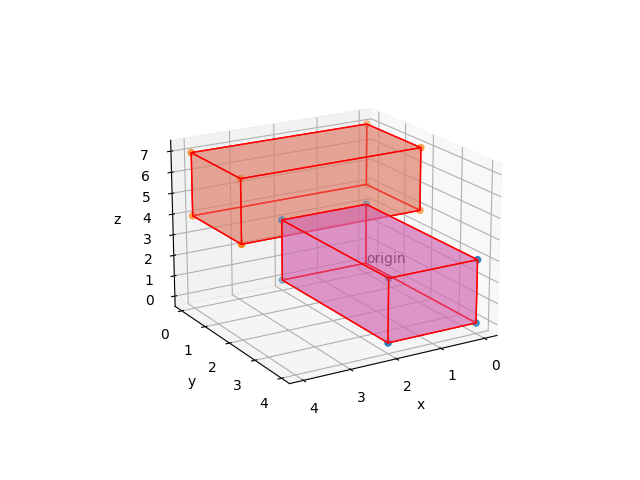

In [103]:
ax = get_pallet()
ax = add_product_to_pallet(ax, (0,0,0), (2, 4, 3))
ax = add_product_to_pallet(ax, (0,0,4), (4, 2, 3))
plt.show()

In [59]:
solver = pywraplp.Solver.CreateSolver('SCIP')

# Variables
# x[i, j] = 1 if item i is packed in bin j.
x = {}
for i in range(ordered_products):
    for j in range(ordered_products):
        x[(i, j)] = solver.IntVar(0, 1, 'x_%i_%i' % (i, j))
        
# y[j] = 1 if bin j is used.
y = {}
for j in range(ordered_products):
    y[j] = solver.IntVar(0, 1, 'y[%i]' % j)
    
# Constraints
# Each item must be in exactly one bin.
for i in range(ordered_products):
    solver.Add(sum(x[i, j] for j in range(ordered_products)) == 1)
    
# The amount packed in each bin cannot exceed its capacity.
for j in range(ordered_products):
    solver.Add(
        sum(x[(i, j)] * order.iloc[i].weight for i in range(ordered_products)) <= y[j] * 2490
    )
    
solver.Minimize(solver.Sum([y[j] for j in range(ordered_products)]))

In [60]:
status = solver.Solve()
if status == pywraplp.Solver.OPTIMAL:
    num_bins = 0.
    for j in range(ordered_products):
        if y[j].solution_value() == 1:
            bin_items = []
            bin_weight = 0
            for i in range(ordered_products):
                if x[i, j].solution_value() > 0:
                    bin_items.append(i)
                    bin_weight += order.iloc[i].weight
            if bin_weight > 0:
                num_bins += 1
                print('Bin number', j)
                print('  Items packed:', bin_items)
                print('  Total weight:', bin_weight)
                print()
    print()
    print('Number of bins used:', num_bins)
    print('Time = ', solver.WallTime(), ' milliseconds')
else:
    print('The problem does not have an optimal solution.')

Bin number 0
  Items packed: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  Total weight: 883.1700000000001


Number of bins used: 1.0
Time =  3478  milliseconds
